# About RBMs

Let us assume we have $d$ visible units and $n$ hidden units.


Energy of an RBM

$$
E(v,h) = - b^Tv - c^Th - h^t W v
$$

Probability of an assignment of hidden and visible units:

$$
P(v,h) = - \frac{ e^{-E(v,h)} } { \sum_{( \bar{v},\bar{h}) \in \{0,1\}^d x \{0,1\}^n } e^{-E(\bar{v},\bar{h})} }
$$




## Related papers

#### Investigating convergence of RBM learning:
- http://www.ais.uni-bonn.de/papers/nips10ws_schulz_mueller_behnke.pdf

In [1]:
ls

Dataset/            rbm copy.py         rbm_notebook.ipynb
papers/             rbm.py              rbm_numexp.py
parse.py            rbm.pyc             saved_models/
parse.pyc           rbm_imports.py      time_per_pc.txt
plots/              rbm_imports.pyc
pyviennacl.ipynb    rbm_index_data.py


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from timeit import default_timer as timer
from parse import *
import numpy as np
import time
import matplotlib.pyplot as plt
import numexpr  as ne
import profile

In [3]:
def sig(v, numexpr=False):
    if numexpr:
        return ne.evaluate( "1/(1 + exp(-v))")
    else:
        return 1/(1 + np.exp(-v))

def chunks(l, n):
    """
    Yield successive n-sized chunks from l.
    """
    for i in xrange(0, len(l), n):
        yield l[i:i + n]
        
def save_plot(lr, epochs, W):
    #namefile = saved_models_folder + '/' + 'W_layer1' + '_epocs' + str(epochs[0]) + '_lr' + str(lr[0]) + '.npy'

    plt.figure(figsize=(15.2, 15))

    for i, comp in enumerate(W.T):
        plt.subplot(15, 15, i + 1)
        plt.imshow(comp.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

    plt.suptitle('lr = ' + str(lr) + ', epoch =' + str(epochs), fontsize=10)
    plt.savefig('./plots/animation1000ep_CD15/lr_' + str(lr) + '_epoch_' + str(epochs) + '.png', format='png')
    plt.close()
    return


In [4]:
class RBM:

    def __init__(self, visible_dim, hidden_dim, seed=42, mu=0, sigma=0.3, monitor_time=True):
        np.random.seed(seed)
        self.previous_xneg = None
        W = np.random.normal(mu, sigma, [ visible_dim, hidden_dim])
        self.W = np.array(W, dtype='float32')

        np.random.seed(seed)
        b = np.random.normal(mu, sigma, [visible_dim ])
        self.b = np.array(b, dtype='float32')

        np.random.seed(seed)
        c = np.random.normal(mu, sigma, [hidden_dim])
        self.c = np.array(c, dtype='float32')

        self.visible_dim = visible_dim
        self.hidden_dim = hidden_dim

        self.lr = 0
        self.monitor_time = monitor_time
        self.reconstruction_error_evolution = []
        self.reconstruction_error_epoch = 0

    def update_params_cdk(self, Xbatch, lr=0.1, K=1):

        batch_size = Xbatch.shape[0]

        Delta_W = 0
        Delta_b = 0
        Delta_c = 0

        for x in Xbatch:
            xneg = x
        
            for k in xrange(0, k):
                hneg = sig(np.dot(xneg, self.W) + self.c) > np.random.random(self.hidden_dim).astype(np.float32)
                xneg = sig(np.dot(hneg, self.W.T) + self.b) > np.random.random(self.visible_dim).astype(np.float32)
        
            ehp = sig(np.dot(x, self.W) + self.c )
            ehn = sig(np.dot(xneg, self.W) + self.c)

            Delta_W += lr * (np.outer(x, ehp) - np.outer(xneg, ehn))
            Delta_b += lr * (x - xneg)
            Delta_c += lr * (ehp - ehn)

        self.W += Delta_W * (1. / batch_size)
        self.b += Delta_b * (1. / batch_size)
        self.c += Delta_c * (1. / batch_size)


    def update_params_cdk_vectorized(self, Xbatch, lr=0.1, K=1):

        batch_size = Xbatch.shape[0]
        Xneg  = Xbatch

        for k in range(0,K):
            Hneg = sig(np.dot(Xneg , self.W) + self.c) > np.random.random((batch_size, self.hidden_dim)).astype(np.float32)
            Xneg = sig(np.dot(Hneg, self.W.T) + self.b) > np.random.random((batch_size, self.visible_dim)).astype(np.float32)

        Ehp = sig(np.dot(Xbatch, self.W) + self.c)
        Ehn = sig(np.dot(Xneg, self.W) + self.c)

        Delta_W = lr * (np.dot(Xbatch.T, Ehp) - np.dot(Xneg.T, Ehn))
        Delta_b =  np.sum(lr * (Xbatch - Xneg), axis=0)
        Delta_c = np.sum(lr * (Ehp - Ehn), axis=0)
        #error_epoch += np.sum(np.sum((Xbatch-Xneg)**2), axis = 0)
        
        self.W += Delta_W * (1. / batch_size)
        self.b += Delta_b * (1. / batch_size)
        self.c += Delta_c * (1. / batch_size)


    def update_params_cdk_vectorized_ne(self, Xbatch, lr=0.1, K=1):

        batch_size = Xbatch.shape[0]
        Xneg  = Xbatch

        for k in range(0,K):
            Hneg = sig(np.dot(Xneg , self.W) + self.c, numexpr=True) > np.random.random((batch_size, self.hidden_dim)).astype(np.float32)
            Xneg = sig(np.dot(Hneg, self.W.T) + self.b, numexpr=True) > np.random.random((batch_size, self.visible_dim)).astype(np.float32)

        Ehp = sig(np.dot(Xbatch, self.W) + self.c, numexpr=True)
        Ehn = sig(np.dot(Xneg, self.W) + self.c, numexpr=True)

        Delta_W = lr * (np.dot(Xbatch.T, Ehp) - np.dot(Xneg.T, Ehn))
        Delta_b = np.sum(lr * (Xbatch - Xneg), axis=0)
        Delta_c = np.sum(lr * (Ehp - Ehn), axis=0)
        self.reconstruction_error_epoch += np.sum(np.sum((Xbatch-Xneg)**2), axis = 0)
        
        self.W += Delta_W * (1. / batch_size)
        self.b += Delta_b * (1. / batch_size)
        self.c += Delta_c * (1. / batch_size)

    def update_params_pcd(self, Xbatch, lr=0.1, K=1):

        batch_size = Xbatch.shape[0]

        Delta_W = 0
        Delta_b = 0
        Delta_c = 0

        if self.previous_xneg is None:
            xneg = Xbatch[0]

        for x in Xbatch:

            for k in xrange(0, K):
                hneg = sig(np.dot(xneg, self.W) + self.c) > np.random.random(self.hidden_dim).astype(np.float32)
                xneg = sig(np.dot(hneg, self.W.T) + self.b) > np.random.random(self.visible_dim).astype(np.float32)
            
            self.previous_xneg = xneg

            ehp = sig(np.dot(x, self.W) + self.c )
            ehn = sig(np.dot(xneg, self.W) + self.c)

            Delta_W += lr * (np.outer(x, ehp) - np.outer(xneg, ehn))
            Delta_b += lr * (x - xneg)
            Delta_c += lr * (ehp - ehn)

        self.W += Delta_W * (1. / batch_size)
        self.b += Delta_b * (1. / batch_size)
        self.c += Delta_c * (1. / batch_size)

    def fit_minibatch(self, Xbatch, method='CDK_vectorized', lr=0.2, K=5):
        assert method in ['CDK', 'CDK_vectorized', 'CDK_vectorized_numexpr']
        
        if method == 'CDK':
            self.update_params_cdk(Xbatch=Xbatch, lr=lr, K=K)
        
        elif method == 'CDK_vectorized':
            self.update_params_cdk_vectorized(Xbatch=Xbatch, lr=lr, K=K)
        
        elif method == 'CDK_vectorized_numexpr':
            self.update_params_cdk_vectorized_ne(Xbatch=Xbatch, lr=lr, K=K)
        

    def fit(self, X, method='CDK_vectorized', K=2, lr=0.2, epochs=1, batch_size=10, plot_weights=False):

        self.lr = lr
        i = 0
        m = X.shape[0]
        elements = range(m)

        for epoch in range(0, epochs):
            print 'epoch=', epoch+1
            t0 = time.time()

            np.random.shuffle(elements)
            batches = list(chunks(elements, batch_size))

            for batch in batches:
                Xbatch = X[batch, ]
                self.fit_minibatch(Xbatch, method, lr, K)
            
            self.reconstruction_error_evolution.append(self.reconstruction_error_epoch)
            self.reconstruction_error_epoch = 0
            
            if plot_weights:
                save_plot(lr, epoch, W=self.W)

            if self.monitor_time:
                print "time per epoch:", time.time() - t0
            #print self.W[0][0:10]
            i += 1
            
    def plot_weights(self):
        plt.figure(figsize=(15.2, 15))

        for i, comp in enumerate(self.W.T):
            plt.subplot(15, 15, i + 1)
            plt.imshow(comp.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
            plt.xticks(())
            plt.yticks(())

In [5]:
X = read_test()
X_train, label_not_used = read_train(train="./Dataset/train_mnist.csv")
X = np.concatenate((X, X_train), axis=0)  # Use the whole train and test set
X = binarize(X)

saved_models_folder = "saved_models"
visible_dim = X_train.shape[1]
hidden_dim = 225
epochs = 5
lr = 0.1
batch_size = 500

Xaux = np.array(X, dtype='float32')

In [98]:
rbm = RBM(visible_dim=visible_dim, hidden_dim=hidden_dim, seed=42, mu=0, sigma=0.3)
rbm.reconstruction_error_evolution

[]

In [1]:
rbm.fit(Xaux, 
        method='CDK_vectorized',
        K=K,
        lr=lr,
        epochs=epochs,
        batch_size=batch_size,
        plot_weights=False)

NameError: name 'rbm' is not defined

rbm.reconstruction_error_epoch

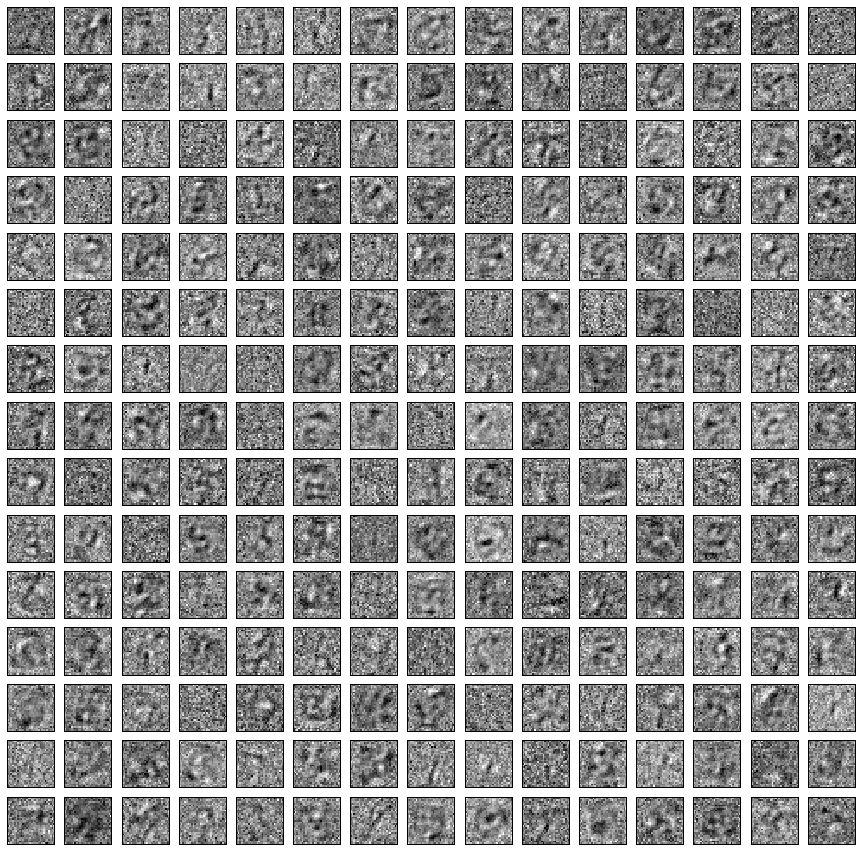

In [100]:
rbm.plot_weights()

## Profiling the code

from the terminal execute
```
 python -m cProfile -o rbm_final_numexp.profile rbm_final_numexp.py 
```
 
This command will create a text file rbm_final_numexp.profile with the information about the profiling of the code.

-  We can load the profiling later with pstats to check how our code is utilizing time


In [31]:
import pstats

p = pstats.Stats('rbm_final_numexp.profile')
p.sort_stats('time') # 'calls' etc
p.print_stats(10)

Thu Nov 19 17:15:05 2015    rbm_final_numexp.profile

         393223 function calls (390443 primitive calls) in 18.464 seconds

   Ordered by: internal time
   List reduced from 2141 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    72136    5.241    0.000    5.241    0.000 {numpy.core.multiarray.array}
     1120    3.878    0.003    3.878    0.003 {numpy.core._dotblas.dot}
      840    3.023    0.004    3.023    0.004 rbm_final_numexp.py:10(sig)
      560    2.155    0.004    2.155    0.004 {method 'random_sample' of 'mtrand.RandomState' objects}
        1    1.438    1.438    4.305    4.305 parse.py:14(read_train)
        1    0.962    0.962    2.868    2.868 parse.py:29(read_test)
      140    0.787    0.006   10.145    0.072 rbm_final_numexp.py:72(update_params_cdk_vectorized)
      569    0.258    0.000    0.258    0.000 {method 'astype' of 'numpy.ndarray' objects}
        1    0.158    0.158    0.158    0.158 {numpy.core.m

<pstats.Stats instance at 0x7f8c0fffc050>

## Annealed Importance Sampling


Some sources and interesting information:

- http://www.cs.toronto.edu/pub/radford/ais-rev.pdf

#### Approximate inference MIT deep learning:
- http://goodfeli.github.io/dlbook/version-2015-10-18/contents/inference.html

#### Confronting the Partition Function:
- http://goodfeli.github.io/dlbook/version-2015-10-18/contents/partition.html




# Cosas raras

Code provided by Ruslan Salakhutdinov 
 
http://www.utstat.toronto.edu/~rsalakhu/rbm_ais.html

